In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import pickle as pkl
import pandas as pd
import os
import requests as r
from sklearn.metrics import accuracy_score
import random

np.random.seed(37)

random.seed(1254)

tf.random.set_seed(89)


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

stages = ['CE', 'SCL']

dataset = 'FairFace'
net = 'R50'
version = 'V1'

stage = stages[0]

script_name_template = '{}-{}-{}-BatchNorm-MultiOutput-{}'
script_name = script_name_template.format(version, dataset, net, stage)

In [2]:
if net == 'R50':
    from tensorflow.keras.applications.resnet_v2 import preprocess_input
    from tensorflow.keras.applications import ResNet50V2 as backbone_net
if net == 'Mnet':
    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    from tensorflow.keras.applications import MobileNetV2 as backbone_net

In [3]:
def encode(data, mask):
    labels = []
    for item in data:
        labels.append(mask[item])
    return labels

In [4]:
if dataset == 'FairFace':
    csv_target_train = '{}/train.csv'.format(dataset)
    csv_target_val = '{}/val.csv'.format(dataset)
    directory_data = dataset
    
    df_train = pd.read_csv(csv_target_train)
    df_val = pd.read_csv(csv_target_val)
    df_train

In [5]:
def label2dict(df):
    values = df.unique()
    d = {}
    for idx, v in enumerate(values):
        d[v] = idx
    return d
def apply_encode(map_dict, col, row):
    return map_dict[row[col]]

In [6]:
target_col = ['gender', 'race', 'age']
num_classes = []
for col in target_col:
    num_classes.append(df_train[col].nunique())
input_shape = (112, 112, 3)
batch_size = 256
learning_rate = 0.001
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05
validation_split = 0.1

In [7]:
target_col_data = []
for col in target_col:
    col2 = col + '_sparse'
    target_col_data.append(col2)
    map_dict = label2dict(df_train[col])
    df_train[col2] = df_train.apply(lambda row: apply_encode(map_dict, col, row), axis=1)
    if dataset == 'FairFace':
        df_val[col2] = df_val.apply(lambda row: apply_encode(map_dict, col, row), axis=1)

In [8]:
x_col = 'file'
y_col = target_col_data
train_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
)
val_generator = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_iter = train_generator.flow_from_dataframe(
    df_train,
    directory=directory_data,
    x_col=x_col,
    y_col=y_col,
    class_mode="multi_output",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
)

val_iter = val_generator.flow_from_dataframe(
    df_val,
    directory=directory_data,
    x_col=x_col,
    y_col=y_col,
    class_mode="multi_output",
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    shuffle=False,
)

Found 86744 validated image filenames.
Found 10954 validated image filenames.


In [9]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.02),
        layers.experimental.preprocessing.RandomWidth(0.2),
        layers.experimental.preprocessing.RandomHeight(0.2),
    ]
)

In [11]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="fairface-encoder")
    return model

In [12]:
def create_classifier(encoder, trainable=True, training=True):
    
    encoder.trainable = trainable

    inputs = keras.Input(shape=input_shape, name="input")
    features = encoder(inputs, training=training)
    outputs = []
    for idx, num_class in enumerate(num_classes):
        _features = layers.Dropout(dropout_rate, name="dropout_" + target_col[idx])(features)
        _features = layers.Dense(hidden_units, activation="relu", name = "features_"+ target_col[idx])(_features)
        _features = layers.Dropout(dropout_rate, name="dropout2_" + target_col[idx])(_features)
        outputs.append(layers.Dense(num_class, activation="softmax", name=target_col[idx])(_features))

    model = keras.Model(inputs=inputs, outputs=outputs, name="classifier")
    metrics = {}
    loss = []
    loss_weights = []
    for col in target_col:
        metrics[col] = keras.metrics.SparseCategoricalAccuracy()
        loss.append(keras.losses.SparseCategoricalCrossentropy())
        loss_weights.append(0.1)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=loss,
        metrics=metrics,
        loss_weights=loss_weights
    )
    return model

In [13]:
encoder = create_encoder()
encoder.summary()
classifier = create_classifier(encoder)
classifier.summary()

Model: "fairface-encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, None, 3)     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________
Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
______________________________________________

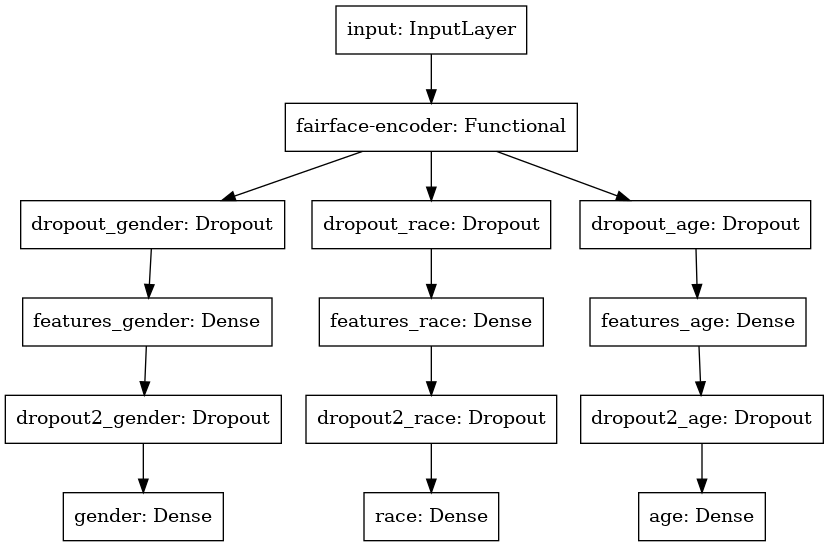

In [14]:
keras.utils.plot_model(classifier)

In [15]:
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, validation_data=val_iter, callbacks=callbacks)

classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Epoch 1/50
339/339 [==============================] - 153s 427ms/step - loss: 0.4053 - gender_loss: 0.6750 - race_loss: 1.5177 - age_loss: 1.8605 - gender_sparse_categorical_accuracy: 0.6074 - race_sparse_categorical_accuracy: 0.3271 - age_sparse_categorical_accuracy: 0.3018 - val_loss: 0.3619 - val_gender_loss: 0.5800 - val_race_loss: 1.3560 - val_age_loss: 1.6834 - val_gender_sparse_categorical_accuracy: 0.6827 - val_race_sparse_categorical_accuracy: 0.4250 - val_age_sparse_categorical_accuracy: 0.3453


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
339/339 [==============================] - 98s 290ms/step - loss: 0.3436 - gender_loss: 0.5193 - race_loss: 1.2906 - age_loss: 1.6263 - gender_sparse_categorical_accuracy: 0.7313 - race_sparse_categorical_accuracy: 0.4600 - age_sparse_categorical_accuracy: 0.3590 - val_loss: 0.3085 - val_gender_loss: 0.4485 - val_race_loss: 1.1287 - val_age_loss: 1.5077 - val_gender_sparse_categorical_accuracy: 0.7767 - val_race_sparse_categorical_accuracy: 0.5367 - val_age_sparse_categorical_accuracy: 0.3946
Epoch 3/50
339/339 [==============================] - 97s 285ms/step - loss: 0.3007 - gender_loss: 0.4235 - race_loss: 1.1016 - age_loss: 1.4816 - gender_sparse_categorical_accuracy: 0.7940 - race_sparse_categorical_accuracy: 0.5514 - age_sparse_categorical_accuracy: 0.4030 - val_loss: 0.2802 - val_gender_loss: 0.3895 - val_race_loss: 1.0132 - val_age_loss: 1.3988 - val_gender_sparse_categorical_accuracy: 0.8128 - val_race_sparse_categorical_accuracy: 0.5916 - val_age_sparse_categorical

339/339 [==============================] - 91s 269ms/step - loss: 0.1985 - gender_loss: 0.2206 - race_loss: 0.6893 - age_loss: 1.0750 - gender_sparse_categorical_accuracy: 0.9031 - race_sparse_categorical_accuracy: 0.7330 - age_sparse_categorical_accuracy: 0.5415 - val_loss: 0.2045 - val_gender_loss: 0.2469 - val_race_loss: 0.6952 - val_age_loss: 1.1033 - val_gender_sparse_categorical_accuracy: 0.8939 - val_race_sparse_categorical_accuracy: 0.7253 - val_age_sparse_categorical_accuracy: 0.5330
Epoch 19/50
339/339 [==============================] - 92s 270ms/step - loss: 0.1962 - gender_loss: 0.2153 - race_loss: 0.6802 - age_loss: 1.0670 - gender_sparse_categorical_accuracy: 0.9058 - race_sparse_categorical_accuracy: 0.7378 - age_sparse_categorical_accuracy: 0.5475 - val_loss: 0.2016 - val_gender_loss: 0.2319 - val_race_loss: 0.6960 - val_age_loss: 1.0877 - val_gender_sparse_categorical_accuracy: 0.8996 - val_race_sparse_categorical_accuracy: 0.7249 - val_age_sparse_categorical_accuracy:

339/339 [==============================] - 92s 270ms/step - loss: 0.1648 - gender_loss: 0.1520 - race_loss: 0.5487 - age_loss: 0.9468 - gender_sparse_categorical_accuracy: 0.9364 - race_sparse_categorical_accuracy: 0.7926 - age_sparse_categorical_accuracy: 0.5917 - val_loss: 0.1886 - val_gender_loss: 0.2116 - val_race_loss: 0.6392 - val_age_loss: 1.0349 - val_gender_sparse_categorical_accuracy: 0.9146 - val_race_sparse_categorical_accuracy: 0.7560 - val_age_sparse_categorical_accuracy: 0.5594
Epoch 35/50
339/339 [==============================] - 92s 272ms/step - loss: 0.1623 - gender_loss: 0.1485 - race_loss: 0.5373 - age_loss: 0.9370 - gender_sparse_categorical_accuracy: 0.9377 - race_sparse_categorical_accuracy: 0.7970 - age_sparse_categorical_accuracy: 0.5952 - val_loss: 0.1899 - val_gender_loss: 0.2071 - val_race_loss: 0.6462 - val_age_loss: 1.0455 - val_gender_sparse_categorical_accuracy: 0.9158 - val_race_sparse_categorical_accuracy: 0.7530 - val_age_sparse_categorical_accuracy:

339/339 [==============================] - 91s 269ms/step - loss: 0.1403 - gender_loss: 0.1130 - race_loss: 0.4416 - age_loss: 0.8483 - gender_sparse_categorical_accuracy: 0.9539 - race_sparse_categorical_accuracy: 0.8329 - age_sparse_categorical_accuracy: 0.6315 - val_loss: 0.1927 - val_gender_loss: 0.2055 - val_race_loss: 0.6670 - val_age_loss: 1.0543 - val_gender_sparse_categorical_accuracy: 0.9191 - val_race_sparse_categorical_accuracy: 0.7558 - val_age_sparse_categorical_accuracy: 0.5642


In [16]:
stage = stages[1]
script_name = script_name_template.format(version, dataset, net, stage)

In [17]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = []
    for col in target_col:
        outputs.append(layers.Dense(projection_units, activation="relu", name="features_" + col)(features))
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="encoder_with_projection-head"
    )
    return model

Model: "encoder_with_projection-head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
fairface-encoder (Functional)   (None, 2048)         23564800    input_5[0][0]                    
__________________________________________________________________________________________________
features_gender (Dense)         (None, 128)          262272      fairface-encoder[0][0]           
__________________________________________________________________________________________________
features_race (Dense)           (None, 128)          262272      fairface-encoder[0][0]           
_______________________________________________________________________

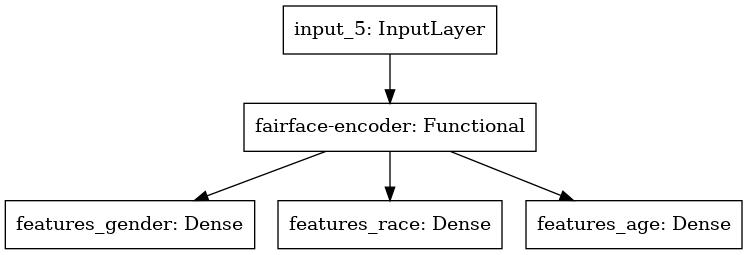

In [18]:
encoder = create_encoder()
loss = []
loss_weights = []
for col in target_col:
    loss.append(SupervisedContrastiveLoss(temperature))
    loss_weights.append(0.1)
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=loss,
    loss_weights=loss_weights
)

encoder_with_projection_head.summary()
keras.utils.plot_model(encoder_with_projection_head)

In [19]:
history = encoder_with_projection_head.fit(
    train_iter, batch_size=batch_size, epochs=num_epochs
)


Epoch 1/50
339/339 [==============================] - 86s 240ms/step - loss: 1.6592 - features_gender_loss: 5.5447 - features_race_loss: 5.5271 - features_age_loss: 5.5200
Epoch 2/50
339/339 [==============================] - 81s 238ms/step - loss: 1.6392 - features_gender_loss: 5.5014 - features_race_loss: 5.4693 - features_age_loss: 5.4218
Epoch 3/50
339/339 [==============================] - 81s 238ms/step - loss: 1.6157 - features_gender_loss: 5.4358 - features_race_loss: 5.3741 - features_age_loss: 5.3474
Epoch 4/50
339/339 [==============================] - 81s 239ms/step - loss: 1.5957 - features_gender_loss: 5.3892 - features_race_loss: 5.2867 - features_age_loss: 5.2815
Epoch 5/50
339/339 [==============================] - 82s 240ms/step - loss: 1.5805 - features_gender_loss: 5.3553 - features_race_loss: 5.2256 - features_age_loss: 5.2242
Epoch 6/50
339/339 [==============================] - 81s 240ms/step - loss: 1.5682 - features_gender_loss: 5.3219 - features_race_loss: 5.1

339/339 [==============================] - 81s 239ms/step - loss: 1.4492 - features_gender_loss: 5.0241 - features_race_loss: 4.6532 - features_age_loss: 4.8147
Epoch 49/50
339/339 [==============================] - 81s 240ms/step - loss: 1.4475 - features_gender_loss: 5.0179 - features_race_loss: 4.6462 - features_age_loss: 4.8105
Epoch 50/50
339/339 [==============================] - 81s 238ms/step - loss: 1.4464 - features_gender_loss: 5.0174 - features_race_loss: 4.6411 - features_age_loss: 4.8051


<Response [200]>

In [20]:
callbacks = []
if len(target_col) == 1:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)
else:
    for col in target_col:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath='./ckpt/{}-{}.h5'.format(script_name, col),
            monitor='val_{}_sparse_categorical_accuracy'.format(col),
            mode='max',
            save_best_only=True)
        callbacks.append(model_checkpoint_callback)

In [21]:
classifier = create_classifier(encoder, trainable=False, training=False)
history = classifier.fit(train_iter, batch_size=batch_size, epochs=10, validation_data=val_iter, callbacks=callbacks)

Epoch 1/10
339/339 [==============================] - 94s 270ms/step - loss: 0.1455 - gender_loss: 0.0850 - race_loss: 0.4380 - age_loss: 0.9324 - gender_sparse_categorical_accuracy: 0.9708 - race_sparse_categorical_accuracy: 0.8539 - age_sparse_categorical_accuracy: 0.6155 - val_loss: 0.1943 - val_gender_loss: 0.2539 - val_race_loss: 0.6517 - val_age_loss: 1.0375 - val_gender_sparse_categorical_accuracy: 0.9231 - val_race_sparse_categorical_accuracy: 0.7676 - val_age_sparse_categorical_accuracy: 0.5677


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
339/339 [==============================] - 90s 264ms/step - loss: 0.1320 - gender_loss: 0.0752 - race_loss: 0.3967 - age_loss: 0.8479 - gender_sparse_categorical_accuracy: 0.9747 - race_sparse_categorical_accuracy: 0.8640 - age_sparse_categorical_accuracy: 0.6392 - val_loss: 0.1948 - val_gender_loss: 0.2252 - val_race_loss: 0.6660 - val_age_loss: 1.0563 - val_gender_sparse_categorical_accuracy: 0.9245 - val_race_sparse_categorical_accuracy: 0.7648 - val_age_sparse_categorical_accuracy: 0.5693
Epoch 3/10
339/339 [==============================] - 91s 267ms/step - loss: 0.1300 - gender_loss: 0.0717 - race_loss: 0.3887 - age_loss: 0.8394 - gender_sparse_categorical_accuracy: 0.9751 - race_sparse_categorical_accuracy: 0.8645 - age_sparse_categorical_accuracy: 0.6409 - val_loss: 0.1977 - val_gender_loss: 0.2197 - val_race_loss: 0.6900 - val_age_loss: 1.0670 - val_gender_sparse_categorical_accuracy: 0.9247 - val_race_sparse_categorical_accuracy: 0.7639 - val_age_sparse_categorical

<Response [200]>

In [22]:
classifier.trainable = True
classifier.summary()
history = classifier.fit(train_iter, batch_size=batch_size, epochs=num_epochs, initial_epoch=10, validation_data=val_iter, callbacks=callbacks)
classifier.save('./ckpt/{}-{}.h5'.format(script_name, 'last'))

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
fairface-encoder (Functional)   (None, 2048)         23564800    input[0][0]                      
__________________________________________________________________________________________________
dropout_gender (Dropout)        (None, 2048)         0           fairface-encoder[1][0]           
__________________________________________________________________________________________________
dropout_race (Dropout)          (None, 2048)         0           fairface-encoder[1][0]           
_________________________________________________________________________________________

Epoch 21/50
339/339 [==============================] - 90s 266ms/step - loss: 0.1258 - gender_loss: 0.0650 - race_loss: 0.3729 - age_loss: 0.8203 - gender_sparse_categorical_accuracy: 0.9775 - race_sparse_categorical_accuracy: 0.8703 - age_sparse_categorical_accuracy: 0.6468 - val_loss: 0.1966 - val_gender_loss: 0.2356 - val_race_loss: 0.6680 - val_age_loss: 1.0627 - val_gender_sparse_categorical_accuracy: 0.9255 - val_race_sparse_categorical_accuracy: 0.7683 - val_age_sparse_categorical_accuracy: 0.5689
Epoch 22/50
339/339 [==============================] - 90s 264ms/step - loss: 0.1256 - gender_loss: 0.0643 - race_loss: 0.3720 - age_loss: 0.8192 - gender_sparse_categorical_accuracy: 0.9777 - race_sparse_categorical_accuracy: 0.8704 - age_sparse_categorical_accuracy: 0.6483 - val_loss: 0.1988 - val_gender_loss: 0.2382 - val_race_loss: 0.6851 - val_age_loss: 1.0650 - val_gender_sparse_categorical_accuracy: 0.9251 - val_race_sparse_categorical_accuracy: 0.7657 - val_age_sparse_categoric

339/339 [==============================] - 89s 264ms/step - loss: 0.1245 - gender_loss: 0.0615 - race_loss: 0.3674 - age_loss: 0.8162 - gender_sparse_categorical_accuracy: 0.9790 - race_sparse_categorical_accuracy: 0.8720 - age_sparse_categorical_accuracy: 0.6490 - val_loss: 0.1994 - val_gender_loss: 0.2307 - val_race_loss: 0.7021 - val_age_loss: 1.0607 - val_gender_sparse_categorical_accuracy: 0.9243 - val_race_sparse_categorical_accuracy: 0.7656 - val_age_sparse_categorical_accuracy: 0.5698
Epoch 38/50
339/339 [==============================] - 90s 264ms/step - loss: 0.1245 - gender_loss: 0.0622 - race_loss: 0.3677 - age_loss: 0.8149 - gender_sparse_categorical_accuracy: 0.9783 - race_sparse_categorical_accuracy: 0.8710 - age_sparse_categorical_accuracy: 0.6499 - val_loss: 0.2002 - val_gender_loss: 0.2469 - val_race_loss: 0.6803 - val_age_loss: 1.0744 - val_gender_sparse_categorical_accuracy: 0.9256 - val_race_sparse_categorical_accuracy: 0.7676 - val_age_sparse_categorical_accuracy:

In [23]:
res = []
names = []
for stage in stages:
    names.append(script_name_template.format(version, dataset, net, stage) + '-{}.h5')
for name in names:
    for col in target_col + ['last']:
        model_file = 'ckpt/' + name.format(col)
        model = keras.models.load_model(model_file)
        eval_res = model.evaluate(val_iter)
        eval_res = [name.format(col)] + eval_res
        res.append(eval_res)
columns = ['name', 'total_loss']
if len(target_col) == 1:
    columns.append('acc')
else:
    for m in ['loss', 'acc']:
        for col in target_col:
            columns.append('{}_{}'.format(col, m))
df_res = pd.DataFrame(res, columns = columns)
df_res.to_csv('Compare - Scratch - SupCon - {} - {}.csv'.format(version, dataset))

43/43 [==============================] - 11s 233ms/step - loss: 0.2015 - gender_loss: 0.2388 - race_loss: 0.7000 - age_loss: 1.0765 - gender_sparse_categorical_accuracy: 0.9262 - race_sparse_categorical_accuracy: 0.7686 - age_sparse_categorical_accuracy: 0.5624
